In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

import tensorflow as tf
import tensorflow.keras
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import optimizers, utils, initializers, regularizers
from tensorflow.keras.callbacks import EarlyStopping

import itertools as it

In [ ]:
# read dataframe of links
embedding_df_pickle = pd.read_pickle('embedding_pickle.csv')

In [ ]:
embedding_df_pickle.head(5)

,first,second,link
0,"[0.078552246, 0.1998291, 0.11755371, 0.1346435...","[-0.1375, 0.10991211, 0.13271484, 0.05996094, ...",1
1,"[0.078552246, 0.1998291, 0.11755371, 0.1346435...","[-0.19732666, 0.035949707, 0.16992188, 0.08459...",1
2,"[0.078552246, 0.1998291, 0.11755371, 0.1346435...","[-0.265625, -0.16503906, 0.12402344, 0.1982421...",1
3,"[0.078552246, 0.1998291, 0.11755371, 0.1346435...","[-0.099121094, 0.07373047, 0.0625, -0.12207031...",1
4,"[0.078552246, 0.1998291, 0.11755371, 0.1346435...","[0.5434049417909654, 0.27836938509379616, 0.42...",1


In [ ]:
embedding_df_pickle.dtypes

first     object
second    object
link      object
dtype: object

In [ ]:
embedding_df_pickle['mixed'] = 0
embedding_df_pickle.mixed = embedding_df_pickle.mixed.astype(object)

In [ ]:
for i in range(embedding_df_pickle.shape[0]):
    first = embedding_df_pickle.iloc[i][0]
    second = embedding_df_pickle.iloc[i][1]
    mixed = np.concatenate((first, second), 0)
    embedding_df_pickle.loc[i, 'mixed'] = mixed

In [ ]:
X = embedding_df_pickle['mixed'].values

In [ ]:
# creating matrix
b = X[0]
b = b.reshape((1,600))
b.shape
result = np.zeros((X.shape[0], b.shape[1]))
for i,v in enumerate(X):
    print(str(i)+" ", end='')
    v = v.reshape((1, 600))
    result[i] = v

In [ ]:
X = result

In [ ]:
Y = embedding_df_pickle[['link']].values
Y=Y.astype('int')

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, 
                                                test_size = 0.3, 
                                                random_state = 35, stratify=Y)

In [ ]:
xtrain, xval, ytrain, yval = train_test_split(xtrain, ytrain, 
                                                test_size = 0.3, 
                                                random_state = 35, stratify=ytrain)

In [ ]:
ytrain.shape

(69146, 1)

In [ ]:
ytrain

array([[1],
       [1],
       [1],
       ...,
       [0],
       [1],
       [0]])

In [ ]:
unique, counts = np.unique(ytrain, return_counts=True)
print(np.asarray((unique, counts)).T)

[[    0 34530]
 [    1 34616]]


In [ ]:
lr = LogisticRegression()

lr.fit(xtrain, ytrain)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
predictions = lr.predict_proba(xtest)

In [ ]:
predictions = predictions[:,1]
fpr_lr, tpr_lr, threshold_lr = metrics.roc_curve(ytest, predictions)
auc_lr = auc(fpr_lr, tpr_lr)

In [ ]:
def create_model(learning_rate=0.1, momentum = 0.9, nesterov = True,
                 activation = 'sigmoid', regularizer = 0.01, units=3, hidden_layers=1):
    # create model
    model = Sequential()
    #initializer = initializers.RandomUniform(minval=0, maxval=0.5, seed=None)
    model.add(Dense(units, input_dim=600, activation = activation, 
                         kernel_regularizer=regularizers.l2(regularizer)))  
    for i in range(1,hidden_layers):
          model.add(Dense(units, activation = activation, 
                         kernel_regularizer=regularizers.l2(regularizer)))  
    model.add(Dense(1, activation = 'sigmoid',  kernel_regularizer=regularizers.l2(regularizer)))
    sgd = optimizers.SGD(learning_rate=learning_rate, momentum=momentum, nesterov=nesterov)
    model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
param_list = {'batch_size': [128],
              'epochs': [100],
             'learning_rate': [0.261],
             'momentum':[0.9],
             'nesterov':[False],
             'activation':['tanh'],
              'regularizer':[0.0001],
              'units': [10],
             'hidden_layers': [1]}

In [ ]:
class Model:
    def __init__(self, loss = 0, accuracy = 0, batch_size = 0, epochs = 0, learning_rate=0, momentum=0,nesterov=False,
                activation='sigmoid', regularizer=0, units=0):
        self.accuracy_CV_list = []
        self.accuracy = accuracy
        self.loss_CV_list = []
        self.loss = loss
        self.mee_list = []
        self.mee = 0
        self.std = 0
        self.batch_size = batch_size
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.nesterov = nesterov
        self.activation = activation
        self.regularizer = regularizer
        self.units = units
        self.noise = 0
    def toString(self):
        print("""{MEE: %f (+/- %0.2f), Number of Units: %d, Batch Size: %d, Epochs: %d, Learning Rate: %f, Momentum: %f,
              "Nesterov: %s, Activation: %s, Regularization: %f, Noise: %f}""" % 
              (self.mee, self.std, self.units, self.batch_size, self.epochs, self.learning_rate, self.momentum,
              self.nesterov, self.activation, self.regularizer, self.noise))

In [ ]:
def GridSearch(X_train, Y_train, parameters, cv = 3, rand=False):
    models = []
    allNames = list(parameters)
    combinations = it.product(*(parameters[Name] for Name in allNames))
    searchList = []
    if rand:
        searchList = random.sample(list(combinations), k=100)
    else:
        searchList = list(combinations)
    for i in searchList:
        print(searchList.index(i), i)
        batch_size = i[0]
        epochs=i[1]
        learning_rate=i[2]
        momentum=i[3]
        nesterov=i[4]
        activation=i[5]
        regularizer=i[6]
        units = i[7]
        temp = Model(batch_size=batch_size, epochs=epochs, learning_rate=learning_rate,
                     momentum=momentum, nesterov=nesterov, activation=activation, regularizer=regularizer, units=units)
        model = None # Clearing the NN.
        model = create_model(learning_rate=learning_rate, momentum=momentum, nesterov=nesterov, 
                                 activation=activation, regularizer=regularizer, units=units)
        r = model.fit(X_train, Y_train,validation_split = float(1.0/cv),
                      batch_size =batch_size, epochs=epochs, verbose=1)
        loss = r.history['val_loss'][-1]
        #accuracy = r.history['val_acc'][-1]
        temp.loss = loss
        #temp.accuracy = accuracy
        models.append(temp) 
          
    result = sorted(models, key=lambda x: x.loss, reverse=False)
    return result, r, model

In [ ]:
allModels, r, model = GridSearch(xtrain, ytrain, param_list, cv=3, rand=False)

0 (128, 100, 0.261, 0.9, False, 'tanh', 0.0001, 10, 1)
Epoch 1/100
361/361 [==============================] - 1s 3ms/step - loss: 0.6979 - accuracy: 0.5045 - val_loss: 0.6940 - val_accuracy: 0.5189
Epoch 2/100
361/361 [==============================] - 1s 3ms/step - loss: 0.6707 - accuracy: 0.5895 - val_loss: 0.6655 - val_accuracy: 0.6113
Epoch 3/100
361/361 [==============================] - 1s 3ms/step - loss: 0.6444 - accuracy: 0.6343 - val_loss: 0.6477 - val_accuracy: 0.6328
Epoch 4/100
361/361 [==============================] - 1s 3ms/step - loss: 0.6347 - accuracy: 0.6436 - val_loss: 0.6480 - val_accuracy: 0.6313
Epoch 5/100
361/361 [==============================] - 1s 3ms/step - loss: 0.6250 - accuracy: 0.6602 - val_loss: 0.6438 - val_accuracy: 0.6529
Epoch 6/100
361/361 [==============================] - 1s 3ms/step - loss: 0.6120 - accuracy: 0.6810 - val_loss: 0.6470 - val_accuracy: 0.6392
Epoch 7/100
361/361 [==============================] - 1s 3ms/step - loss: 0.5986 - acc

In [ ]:
pred = model.predict_classes(xtest)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [ ]:
y_pred_keras = model.predict(xtest).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(ytest, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)

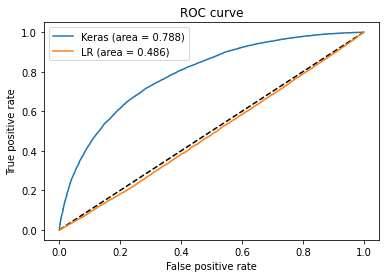

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_lr, tpr_lr, label='LR (area = {:.3f})'.format(auc_lr))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

### Checking link predictions in the dataframe
these phases of work are carried out using in the meantime the file WordEmbedding to get words

In [ ]:
# showing examples of predictions
pred[0:20]

array([[0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1]], dtype=int32)

In [ ]:
xtest[2][0:300].mean()
# to check what word corrispond, we used vector mean

-0.011751492818196615

In [ ]:
xtest[2][300:].mean()

-0.031591059366861976

### Checking link predictions with new words

In [ ]:
#create first word array
sample_xtest_0 = np.array([ 5.78613281e-02,  1.36718750e-01,  1.69921875e-01,  7.27539062e-02,
       -1.51367188e-01, -1.47247314e-03, -1.51367188e-01, -3.12500000e-01,
       -7.12890625e-02,  2.61718750e-01,  2.33650208e-04, -6.07910156e-02,
        9.52148438e-02, -1.12792969e-01, -5.81054688e-02,  4.58984375e-02,
        1.89208984e-02, -2.39257812e-02,  4.98046875e-02,  1.61132812e-01,
        1.25000000e-01,  1.63574219e-02,  1.85546875e-01, -6.49414062e-02,
        2.61230469e-02,  5.41992188e-02, -5.22460938e-02,  3.36914062e-02,
       -2.11914062e-01,  1.04492188e-01,  9.22851562e-02, -8.83789062e-02,
       -2.67028809e-03,  1.14746094e-01, -4.19921875e-02, -2.38281250e-01,
       -2.75390625e-01,  4.24804688e-02, -4.32128906e-02,  6.83593750e-02,
        6.39648438e-02,  1.58203125e-01,  1.59179688e-01,  4.02832031e-02,
       -3.20434570e-03,  1.81640625e-01, -1.86767578e-02,  3.59375000e-01,
       -6.73828125e-02,  1.67968750e-01, -1.98242188e-01,  3.39843750e-01,
        1.57470703e-02,  1.46484375e-02, -1.32812500e-01,  2.73437500e-01,
       -3.04687500e-01, -8.25195312e-02, -1.26953125e-01, -9.17968750e-02,
       -1.44531250e-01,  1.09252930e-02,  2.31933594e-02, -3.61328125e-01,
       -2.18505859e-02, -1.27929688e-01,  6.59179688e-02, -2.77343750e-01,
        2.91015625e-01, -5.78613281e-02, -1.03515625e-01, -2.11181641e-02,
       -2.61718750e-01,  1.26953125e-01,  1.89208984e-02, -1.92382812e-01,
       -2.16674805e-03, -2.67333984e-02, -6.50024414e-03,  1.25000000e-01,
        2.41699219e-02, -2.15820312e-01,  8.05664062e-02, -3.39843750e-01,
        3.03955078e-02, -2.25585938e-01, -1.73828125e-01,  4.58984375e-02,
        1.62109375e-01,  1.93359375e-01,  1.24023438e-01, -1.21582031e-01,
       -3.24218750e-01,  1.51367188e-01,  1.69677734e-02, -3.16406250e-01,
       -6.20117188e-02, -5.11718750e-01,  1.54296875e-01, -6.34765625e-02,
       -4.02343750e-01, -8.93554688e-02, -8.10546875e-02,  1.21093750e-01,
        1.35742188e-01, -6.65283203e-03, -2.31933594e-02, -8.00781250e-02,
        6.64062500e-02, -1.85546875e-02,  2.14843750e-01,  6.88476562e-02,
        1.07421875e-01, -2.41210938e-01,  3.44238281e-02,  1.48315430e-02,
       -7.61718750e-02,  7.41577148e-03,  5.15625000e-01,  1.45507812e-01,
       -1.87500000e-01, -2.75390625e-01,  8.34960938e-02,  7.66601562e-02,
        1.30859375e-01, -3.53515625e-01, -2.90527344e-02, -1.56250000e-01,
       -5.85937500e-01,  2.35351562e-01, -1.63085938e-01, -2.73437500e-01,
       -2.28515625e-01, -1.01562500e-01,  1.46484375e-01, -1.43554688e-01,
       -1.08886719e-01,  6.25000000e-02,  4.19921875e-01, -2.30468750e-01,
        3.55468750e-01, -1.11328125e-01,  1.39648438e-01,  2.35351562e-01,
        2.32421875e-01,  1.42822266e-02, -3.29589844e-02,  2.24609375e-01,
        8.54492188e-02, -1.51367188e-01,  5.46264648e-03,  9.03320312e-02,
        7.12890625e-02,  5.12695312e-02,  1.05957031e-01, -1.76757812e-01,
       -2.08007812e-01,  1.97265625e-01,  6.00585938e-02,  3.12500000e-01,
        3.93066406e-02,  5.46875000e-02, -1.09252930e-02, -5.49316406e-02,
        1.73828125e-01, -1.03027344e-01, -1.45263672e-02, -3.68652344e-02,
        6.73828125e-02,  4.85839844e-02, -3.45703125e-01,  9.91210938e-02,
       -5.29785156e-02,  1.34887695e-02, -9.17968750e-02, -1.41601562e-01,
        1.45507812e-01,  5.52368164e-03,  7.22656250e-02,  2.90527344e-02,
        4.90722656e-02, -3.53515625e-01, -8.10546875e-02,  5.02929688e-02,
        2.61718750e-01,  8.74023438e-02,  1.76757812e-01, -4.22363281e-02,
       -3.69140625e-01,  3.18527222e-04,  4.73632812e-02, -1.52343750e-01,
        1.15234375e-01,  5.49316406e-02, -1.11328125e-01,  1.74804688e-01,
        2.13867188e-01, -2.25830078e-02,  2.68554688e-02, -2.36328125e-01,
        1.10839844e-01, -1.80664062e-02, -1.42578125e-01, -6.29882812e-02,
        3.78417969e-02, -8.34960938e-02, -1.63085938e-01, -1.55273438e-01,
       -6.34765625e-02, -9.76562500e-02, -5.44433594e-02, -1.43554688e-01,
       -6.25000000e-02,  2.13867188e-01, -2.73437500e-01, -3.02124023e-03,
       -4.11987305e-03,  1.33789062e-01,  3.10058594e-02, -1.40380859e-02,
       -1.35498047e-02, -1.83593750e-01, -1.69921875e-01, -1.72851562e-01,
       -1.91406250e-01,  1.20605469e-01, -2.99072266e-03,  1.19628906e-01,
        2.28515625e-01,  6.49414062e-02, -1.93359375e-01,  1.63085938e-01,
        8.44726562e-02, -3.29589844e-02, -4.94384766e-03,  1.02050781e-01,
       -9.52148438e-02,  2.73437500e-01, -1.24511719e-01, -9.08203125e-02,
        7.12890625e-02, -6.78710938e-02,  1.90429688e-01,  3.32031250e-01,
       -8.39843750e-02, -9.88769531e-03, -7.42187500e-02, -1.72851562e-01,
        1.92260742e-03, -8.05664062e-02,  3.04687500e-01,  2.86865234e-02,
        1.44531250e-01,  1.40991211e-02,  2.81982422e-02,  2.50000000e-01,
        1.09863281e-01, -1.04980469e-01,  1.57226562e-01,  2.73437500e-02,
        1.15722656e-01,  8.98437500e-02,  2.51770020e-03,  2.79296875e-01,
        1.98242188e-01, -6.73828125e-02, -3.47656250e-01,  7.44628906e-03,
        5.59082031e-02, -1.11694336e-02,  3.00292969e-02,  8.39843750e-02,
       -6.54296875e-02, -6.44531250e-02,  3.71093750e-01, -1.30615234e-02,
       -1.27929688e-01,  2.24609375e-02, -8.48388672e-03,  2.55126953e-02,
       -1.71875000e-01,  1.87500000e-01, -2.49023438e-02,  5.46264648e-03,
       -3.06640625e-01,  9.57031250e-02,  2.09960938e-02,  8.72802734e-03,
       -2.45117188e-01,  7.61718750e-02, -4.34570312e-02,  4.00390625e-02,
       -3.32031250e-01,  1.01074219e-01,  4.34570312e-02,  2.61718750e-01,
       -1.30859375e-01, -1.14257812e-01,  7.86132812e-02, -1.44531250e-01])

In [ ]:
#create second word array
sample_xtest_1 = np.array([ 1.30859375e-01, -7.71484375e-02, -1.33789062e-01,  2.17773438e-01,
       -2.94921875e-01,  2.70996094e-02, -1.68945312e-01,  7.27539062e-02,
        8.98437500e-02,  2.92968750e-01, -1.36718750e-01, -1.99218750e-01,
        2.17285156e-02, -6.59179688e-02, -1.24511719e-01,  1.86523438e-01,
       -8.59375000e-02, -1.22070312e-02,  6.34765625e-02, -1.26953125e-01,
        2.61718750e-01, -2.69531250e-01, -1.00585938e-01,  1.05957031e-01,
        5.44433594e-02,  6.93359375e-02, -7.89642334e-04,  3.59375000e-01,
       -3.43750000e-01,  2.89062500e-01,  2.61718750e-01,  1.51367188e-01,
       -3.44238281e-02, -1.06933594e-01,  2.57812500e-01, -3.28125000e-01,
       -6.80541992e-03, -1.23535156e-01, -5.37109375e-02,  2.47070312e-01,
        5.39550781e-02, -1.14257812e-01,  6.10351562e-02,  1.92382812e-01,
       -3.14453125e-01, -2.87109375e-01, -5.05371094e-02,  3.69140625e-01,
       -4.71191406e-02,  3.55468750e-01, -1.28906250e-01,  4.80468750e-01,
       -1.14257812e-01, -3.00292969e-02, -8.25195312e-02,  9.76562500e-02,
        1.56250000e-02,  5.24902344e-02, -4.41406250e-01, -1.92382812e-01,
        3.68652344e-02, -8.54492188e-02,  1.95312500e-01, -1.20117188e-01,
        3.00781250e-01, -7.66601562e-02, -1.41601562e-01,  1.57226562e-01,
        3.49121094e-02, -1.77001953e-02,  3.00781250e-01, -2.08984375e-01,
       -1.16210938e-01,  4.78515625e-02, -1.35742188e-01, -3.54003906e-03,
        3.78906250e-01, -2.06054688e-01,  1.13769531e-01,  1.32812500e-01,
       -2.67578125e-01, -1.60156250e-01,  5.81054688e-02, -6.83593750e-02,
        6.12792969e-02, -2.01416016e-02, -1.13769531e-01,  1.16210938e-01,
       -1.07421875e-01, -8.00781250e-02,  2.39257812e-01, -2.91015625e-01,
        1.00585938e-01,  4.78515625e-02, -4.00390625e-01, -8.15429688e-02,
        6.64062500e-02, -1.07910156e-01, -2.73437500e-01,  1.83593750e-01,
       -1.29882812e-01, -4.27246094e-02, -2.06054688e-01, -1.17797852e-02,
       -1.21093750e-01,  1.10839844e-01,  2.14843750e-01, -1.67968750e-01,
       -1.06445312e-01,  1.72851562e-01,  1.18164062e-01, -9.86328125e-02,
        4.35546875e-01,  9.15527344e-03, -1.75781250e-01, -1.53320312e-01,
       -9.96093750e-02, -3.53515625e-01,  1.82617188e-01,  2.27539062e-01,
       -4.62890625e-01, -2.15820312e-01,  2.94921875e-01, -6.54296875e-02,
        4.41406250e-01, -1.82617188e-01, -1.88476562e-01, -3.56445312e-02,
       -2.71484375e-01,  5.51757812e-02, -6.64062500e-02, -2.85156250e-01,
       -1.23535156e-01,  7.12890625e-02,  1.40625000e-01,  4.33349609e-03,
       -1.66992188e-01, -5.37109375e-02,  5.74218750e-01, -3.03955078e-02,
       -1.32751465e-03, -8.39843750e-02, -1.74804688e-01, -1.57226562e-01,
        2.65625000e-01, -6.10351562e-03,  4.10156250e-02,  1.38671875e-01,
        2.51953125e-01, -1.63574219e-02,  2.73437500e-01,  3.43750000e-01,
       -1.43554688e-01,  2.71484375e-01,  2.61718750e-01,  2.25585938e-01,
        1.15966797e-02,  1.97265625e-01,  2.63671875e-01,  3.10546875e-01,
       -9.17968750e-02, -1.16577148e-02, -2.08984375e-01, -2.67578125e-01,
        9.13085938e-02,  6.64062500e-02,  6.54296875e-02, -2.81250000e-01,
        1.26953125e-01, -9.08203125e-02, -1.66015625e-01,  5.41992188e-02,
       -7.61718750e-02, -8.39843750e-02, -2.41210938e-01, -3.54003906e-02,
        9.52148438e-02,  2.20947266e-02, -2.22167969e-02, -2.01171875e-01,
        1.15234375e-01, -2.24609375e-01,  1.79443359e-02,  2.08007812e-01,
       -3.66210938e-02, -2.05078125e-02,  2.00195312e-01, -6.49414062e-02,
        1.40625000e-01, -3.18359375e-01,  4.45556641e-03, -4.00390625e-02,
        3.14453125e-01,  2.94921875e-01, -2.28515625e-01,  5.20019531e-02,
        2.05078125e-01,  8.83789062e-02,  2.36328125e-01, -9.91210938e-02,
        1.03027344e-01, -2.73437500e-01, -1.63574219e-02,  3.90625000e-02,
       -9.96093750e-02,  4.93164062e-02, -4.36401367e-03, -1.15722656e-01,
        1.51367188e-01, -1.04003906e-01, -1.15356445e-02, -3.18359375e-01,
       -2.21679688e-01,  9.76562500e-02, -2.79541016e-02,  3.12500000e-01,
        2.83203125e-02,  1.97265625e-01, -4.30297852e-03, -1.18164062e-01,
        3.75000000e-01, -6.15234375e-02, -2.08007812e-01, -3.30078125e-01,
        6.34765625e-02,  1.63085938e-01, -2.00195312e-02,  3.51562500e-01,
       -4.44335938e-02, -1.55273438e-01, -3.75000000e-01,  1.45507812e-01,
        2.53906250e-02, -3.63281250e-01,  8.25195312e-02, -1.25976562e-01,
        1.18652344e-01,  1.39648438e-01,  1.52343750e-01, -2.96875000e-01,
        1.42578125e-01,  5.26428223e-04,  6.05468750e-02,  1.53320312e-01,
       -2.67578125e-01,  2.96875000e-01,  2.19726562e-01, -1.64062500e-01,
        1.66992188e-01, -1.30859375e-01,  2.69531250e-01,  2.28271484e-02,
       -1.83105469e-02,  4.85839844e-02,  2.04101562e-01,  6.93359375e-02,
        1.67968750e-01, -1.57470703e-02, -7.56835938e-02, -1.73339844e-02,
        1.28906250e-01,  7.86132812e-02,  2.37304688e-01,  1.37695312e-01,
        1.14257812e-01, -4.91333008e-03, -2.61718750e-01, -1.80664062e-01,
        6.44531250e-02,  1.65039062e-01, -2.06054688e-01, -2.35595703e-02,
       -2.55859375e-01,  1.84570312e-01, -1.96289062e-01,  2.51953125e-01,
       -7.17773438e-02, -4.85229492e-03, -1.02050781e-01, -1.86523438e-01,
       -1.67968750e-01,  2.25585938e-01,  1.61132812e-02,  1.69921875e-01,
       -5.49316406e-02,  6.73828125e-02, -6.88476562e-02,  1.65039062e-01,
       -3.67187500e-01,  3.22265625e-02, -1.38671875e-01, -2.04101562e-01,
       -1.58203125e-01,  8.39843750e-02,  1.88476562e-01,  2.91015625e-01,
       -2.51953125e-01, -8.49609375e-02, -3.29589844e-02, -1.11694336e-02])

In [ ]:
sample_xtest = np.concatenate((sample_xtest_0, sample_xtest_1), 0)

In [ ]:
sample_xtest = sample_xtest.reshape(1,600)

In [ ]:
#check if two words linked
sample_pred = model.predict_classes(sample_xtest)
sample_pred

array([[1]], dtype=int32)